<a href="https://colab.research.google.com/github/sdrangan/introml/blob/master/unit10_cnn/demo3_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the Resnet model

State-of-the-art deep networks have millions of parameters and often takes days to train, even with clusters of high-power GPUs. Unless you have time and lots of cloud credits to burn, reproducing these results is not possible. Fortunately, platforms such as [Hugging Face](https://huggingface.co) now provde an amazing collection of *pre-trained* models that you can download and readily use.


In this demo, we will explore the resnet-18 model developed by Microsoft.  It introduced a key concept called *skip connections* enabling very deep networks.  This model was first presented in the key paper:

> He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).  [arxiv version](https://arxiv.org/abs/1512.03385)

In this demo, you will see how to:
* Load a pre-trained network from Hugging face
* Make predictions on new images with the network

## Loading the Network

We first lload the pre-trained model and pre-processor.

In [2]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Next, we download the pre-trained model.  We download three components:

*  `image_processor`:  This is a pytorch model that will transform the image to the necessary tensor format for the network.
*  `model`:  This is the actual resnet model.  
* `id2label`:  The mapping from the class label indices to the text labels.

In [10]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")
id2label = model.config.id2label



## Exploring the network

First, let's look at the labels this network predicts.  Note that some labels have multiple names for the same item.

In [11]:
print('number of classes = ' + str(len(id2label)))

# 10 randomly selected classes
for i in range(10):
    print(id2label[i])

number of classes = 1000
tench, Tinca tinca
goldfish, Carassius auratus
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
tiger shark, Galeocerdo cuvieri
hammerhead, hammerhead shark
electric ray, crampfish, numbfish, torpedo
stingray
cock
hen
ostrich, Struthio camelus


Let's print the total number of parameters per layer.  You will see the model has about 11 million parameters!  You are lucky someone else trained it for you!

In [14]:
# Iterate through the model's named parameters
total = 0
for name, param in model.named_parameters():
    print(f"Layer: {name} | Number of parameters: {param.numel()}")
    total += param.numel()
print(f"Total number of parameters: {total}")

Layer: resnet.embedder.embedder.convolution.weight | Number of parameters: 9408
Layer: resnet.embedder.embedder.normalization.weight | Number of parameters: 64
Layer: resnet.embedder.embedder.normalization.bias | Number of parameters: 64
Layer: resnet.encoder.stages.0.layers.0.layer.0.convolution.weight | Number of parameters: 36864
Layer: resnet.encoder.stages.0.layers.0.layer.0.normalization.weight | Number of parameters: 64
Layer: resnet.encoder.stages.0.layers.0.layer.0.normalization.bias | Number of parameters: 64
Layer: resnet.encoder.stages.0.layers.0.layer.1.convolution.weight | Number of parameters: 36864
Layer: resnet.encoder.stages.0.layers.0.layer.1.normalization.weight | Number of parameters: 64
Layer: resnet.encoder.stages.0.layers.0.layer.1.normalization.bias | Number of parameters: 64
Layer: resnet.encoder.stages.0.layers.1.layer.0.convolution.weight | Number of parameters: 36864
Layer: resnet.encoder.stages.0.layers.1.layer.0.normalization.weight | Number of parameters

In [ ]:
inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

This demo is slightly faster if you have a GPU instance, although you will be able to run this on a machine only with a CPU.  The GPU on a regular laptop or desktop will not help, so you have to use a custom machine.  If you are running on Google colab, you can access GPUs for free!  

First, you'll need to enable GPUs for the notebook:

* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

You may not always be able to get a GPU.  Also, if you use the free version of colab, the GPU is not the fastest on the market.  But, you should still see a performance benefit.  

Whatever system you use, you can check if you have a GPU be printing the devices.  If a GPU is enabled, you should see a `GPU` in your device list:

## Loading Test Images

We illustrate the network on a test set of elephant images, but you can use any set of images.  Just create a directory, say `elephant`.  Then, put the files that you want to classify in that directory.  Each file must be a `jpg` file.

The elephant photos in this demo were found using the  [Flicker API demo](flickr_images.ipynb) to create this dataset.  I also resized the images to match the VGG16 input shape `(224,224,3)`.  But, you do not need to do that since the pre-processor will do that.

If you are using Google colab, you will need to create a folder on the virtual machine and load the images into that folder.  

Once you have created the directory, let's print the files in the directory.

In [20]:
import os
image_dir = 'elephant'
image_files = []
for f in os.listdir(image_dir):
  if f.endswith('.jpg'):
    image_files.append(f)
    print(f)

elephant_0008.jpg
elephant_0001.jpg
elephant_0004.jpg
elephant_0007.jpg
elephant_0003.jpg
elephant_0006.jpg
elephant_0000.jpg
elephant_0005.jpg
elephant_0002.jpg
elephant_0009.jpg


We can display what some of the images look like

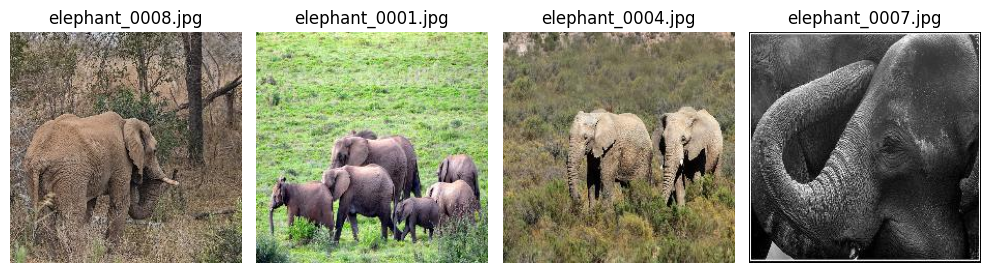

In [42]:
# prompt: Create a subplot to print show the first 4 images

import matplotlib.pyplot as plt
from PIL import Image
import os

# Assuming image_files and image_dir are defined as in the previous code

# Create a figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 10))

# Iterate over the first 4 images
for i, image_file in enumerate(image_files[:4]):
  image_path = os.path.join(image_dir, image_file)
  try:
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(image_file)
    axes[i].axis('off') # Hide axis ticks and labels

  except Exception as e:
    print(f"Error displaying {image_file}: {e}")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Next, we will make a prediction on one of the images.  The output size should be `(nimages, nclasses)` where `nimages` is the number of images in your directory and `nclasses=1000` for the number of classes.

## Making Predictions on the Images
First, we create a pytorch tensor `image_batch` representing the batch of images for all the images in the folder.

In [43]:
image_tensors = []
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  try:
    image = Image.open(image_path)
    inputs = image_processor(image, return_tensors="pt")
    image_tensors.append(inputs['pixel_values'])
  except Exception as e:
    print(f"Error processing {image_file}: {e}")

image_batch = torch.cat(image_tensors, dim=0)
print("Image tensor shape:", image_batch.shape)


Image tensor shape: torch.Size([10, 3, 224, 224])


Now, we run those images through the model.  You will see the output `logits` is `(nimages, nclasses)` where `nimages` is the number of images in your folder and `nclasses=1000` for the number of classes.

In [45]:
with torch.no_grad():
  outputs = model(image_batch)
  logits = outputs.logits

print(logits.shape)

torch.Size([10, 1000])


We will now compute the top 3 classes and their probabilities.  If you are using the elephant images, the network is confused about classifying between african elephants, indian elephants, and tuskers.

In [47]:
# Get probabilities using softmax
probabilities = torch.nn.functional.softmax(logits, dim=-1)

# Find the top 3 classes and their probabilities
ntop = 3
top_prob, top_catid = torch.topk(probabilities, ntop)

# Convert to numpy
top_prob = top_prob.numpy()
top_catid = top_catid.numpy()



res_dict = {}
batch_size = len(image_files)
for j in range(ntop):
    class_names = []
    class_probs = []
    for i in range(batch_size):
        cname = model.config.id2label[top_catid[i][j]]
        class_names.append(cname)
        class_probs.append(top_prob[i][j])

    name_col = str('class %d' % j)
    prob_col = str('prob %d' % j)
    res_dict[name_col] = class_names
    res_dict[prob_col] = class_probs

import pandas as pd
df = pd.DataFrame(data=res_dict)
df

,class 0,prob 0,class 1,prob 1,class 2,prob 2
0,"African elephant, Loxodonta africana",0.471627,tusker,0.406363,"Indian elephant, Elephas maximus",0.118143
1,"African elephant, Loxodonta africana",0.605486,tusker,0.210235,"Indian elephant, Elephas maximus",0.112397
2,"African elephant, Loxodonta africana",0.804041,tusker,0.174265,"Indian elephant, Elephas maximus",0.021363
3,"Indian elephant, Elephas maximus",0.575780,tusker,0.226117,triceratops,0.099790
4,tusker,0.673501,"African elephant, Loxodonta africana",0.264189,"Indian elephant, Elephas maximus",0.062277
5,"African elephant, Loxodonta africana",0.560269,"Indian elephant, Elephas maximus",0.257626,tusker,0.182002
6,"Indian elephant, Elephas maximus",0.443700,tusker,0.284445,"African elephant, Loxodonta africana",0.271502
7,"Indian elephant, Elephas maximus",0.745742,"African elephant, Loxodonta africana",0.223078,tusker,0.031145
8,tusker,0.484950,"Indian elephant, Elephas maximus",0.434523,"African elephant, Loxodonta africana",0.080065
9,"African elephant, Loxodonta africana",0.752204,"Indian elephant, Elephas maximus",0.135210,tusker,0.110573


## Accessing Intermediate Layers

It is useful to visualize the intermediate layers of the network.  One way to do this is to use [forward hooks](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html).  The use is explained nicely in [this post](https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/)

In [51]:
# Specify the layer you want to get activations from
target_layer = 'resnet.encoder.stages.3.layers.0.layer.0.convolution' # Example: Replace with the desired layer name

# Method 1: Using hooks (more flexible)
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register the hook
handle = model.get_submodule(target_layer).register_forward_hook(get_activation(target_layer))

with torch.no_grad():
  outputs = model(image_batch)
  logits = outputs.logits

# Remove the hook
handle.remove()

# Access the activations
intermediate_activations = activations[target_layer]
print(f"Shape of activations for {target_layer}: {intermediate_activations.shape}")# Specify the layer you want to get activations from


Shape of activations for resnet.encoder.stages.3.layers.0.layer.0.convolution: torch.Size([10, 512, 7, 7])


## In-Class Excerise

Find any image of your choice and use the pre-trained network to make a prediction.
* Download the image to your directory
* Load it into an image batch
* Predict the class label and decode the predictions